In [1]:
import os
import sys
import math
import time
import statistics
from datetime import datetime, timedelta
from dateutil import rrule
# import dateutil.relativedelta
import pandas as pd
# import modin.pandas as pd
# os.environ["MODIN_ENGINE"] = "dask" 
import numpy as np
# from dask import dataframe as dd
import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots as subplots
import matplotlib.pyplot as plt
# import scipy.fftpack
# from scipy.signal import find_peaks
# import talib
import pytz
# import MetaTrader5 as mt5
# import random
import os
from binance.client import Client
import ctypes

In [8]:
###### INITIALIZE
def initialize():

    def is_admin():
        try:
            return ctypes.windll.shell32.IsUserAnAdmin()
        except:
            return False

    if not is_admin():
    #     import ctypes 
    #     ctypes.windll.user32.MessageBoxW(0, "ERROR: Restart Jupyter Notebook with administrator rights.", "ERROR", 0)
        print("-- ERROR: Restart Jupyter Notebook with administrator rights.")
        exit()
    #     ctypes.windll.shell32.ShellExecuteW(None, "runas", sys.executable, " ".join(sys.argv), None, 1) #python executable
    else:
        print('-- admin rights granted')

    # demo account:
    # api_key = 'your_api_key'  
    # api_secret = 'your_api_secret'

    api_key ='your_api_key'
    api_secret='your_api_secret'

    client = Client(api_key, api_secret)   #for live
    # client = Client(api_key, api_secret, testnet=True)  # for testnet
    # client.API_URL = 'https://testnet.binance.vision/api'  # demo url change for live account


    server_time = int(client.get_server_time()['serverTime'] /1000)
    if int(time.time()) != server_time :
        import win32api
        tt=time.gmtime(server_time)
        win32api.SetSystemTime(tt[0],tt[1],0,tt[2],tt[3],tt[4],tt[5],0)
        print('-- system time synced')

    if client.get_system_status()['status'] == 1 :
        print('-- ERROR: server undergoing maintenance')
        exit()

    # get balances for all assets & some account information
    # print(client.get_account())

    # get balance for a specific asset only (BTC)
    # print(client.get_asset_balance(asset='BTC'))
    # client.get_products()['data']['s'== 'DOGEUSDT']
    # client.get_symbol_info('DOGEUSDT')
    # client.get_margin_account()

    # #-----------------------------------------------
    # # valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
    # # get timestamp of earliest date data is available
    # timestamp = client._get_earliest_valid_timestamp('DOGEUSDT', '1m')
    # datetime.utcfromtimestamp(int(client._get_earliest_valid_timestamp('DOGEUSDT', '1m')/1000)).strftime('%Y-%m-%d %H:%M:%S')

In [9]:
################ GET DATA ###################### 

def get_data(symbol, time_int, date_from, date_to) :
    then=datetime.now()
    # bars = client.get_historical_klines('BTCUSDT', '1d', timestamp, limit=1000)
    # bars = client.get_historical_klines("BTCUSDT", '1d', "1 Apr, 2021", "1 Apr, 2021")
    # bars =client.get_klines(symbol=symbol, interval='1d',"1 Apr, 2021")
    try:
        bars = client.get_historical_klines(symbol, time_int, date_from, date_to)
        # 0          1     2     3    4      5       6           7                   8              9                            10                             11
        # open time, open, high, low, close, volume, close time, quote asset volume, no. of trades, taker buy base asset volume, taker buy quote asset volume, ignore
        bars=np.array(bars)
        inst =pd.DataFrame(bars[:,[2,3,4,5,6,8]], columns=['high','low','close','volume','datetime','trades'])
        inst=inst.apply(pd.to_numeric)
        # inst['datetime']=pd.to_datetime(inst['datetime']/1000,unit='s') #with miliseconds
        inst['datetime']=pd.to_datetime( (((inst['datetime'])-(inst['datetime']%1000))/1000) ,unit='s')
        del bars

    except:
        print('-- connection failed, try again')
        inst=[]
        
    now=datetime.now()
    print(now-then)
    # inst.tail(3)
    
    return inst

In [10]:
### finds all time highs and lows, single use!

#-----------------
dip_pct=-0.10
#-----------

then=datetime.now()
highest=0
lowest=inst['low'][0]
high_count=0
high_list=[]
low_list=[]
high_list_dt=[]
low_list_dt=[]
dip_thres=False
for high, low, close, dt in zip(inst['high'].to_numpy(),
                                inst['low'].to_numpy(),
                                inst['close'].to_numpy(),
                                inst['datetime'].to_numpy() ) :

    high_count+=1
    if (high >highest) :
        if (dip_thres==True) :
            high_list.append(highest)
            high_list_dt.append(highest_dt)
            low_list.append(lowest)
            low_list_dt.append(lowest_dt)
            dip_thres=False
        highest=high
        highest_dt=dt
        lowest=high
        high_count=0
    if ((low-highest)/highest <= dip_pct) :
        dip_thres=True  
    if (low <lowest) & (highest>0) :
        lowest=low
        lowest_dt=dt

if (dip_thres==True) :
    high_list.append(highest)
    high_list_dt.append(highest_dt)
    low_list.append(lowest)
    low_list_dt.append(lowest_dt)
        
high_df=pd.DataFrame({'high_datetime': high_list_dt, 'highs': high_list,'low_datetime': low_list_dt,'lows': low_list})
high_df['high_pct_change']=high_df['highs'].pct_change(1)
high_df['high_to_low_datetime']=high_df['low_datetime']-high_df['high_datetime']
high_df['prevhigh_to_high_datetime']=high_df['high_datetime'].diff(1)
high_df['high_to_low_pct']=(high_df['lows']-high_df['highs'])/high_df['highs']
high_df['prevlow_to_high_pct']=(high_df['highs']-high_df['lows'].shift(1))/high_df['lows'].shift(1)
del high_list_dt, high_list, low_list_dt, low_list
now=datetime.now()
print(now-then)
print('Mean new highs pct change:',round(high_df['high_pct_change'].mean()*100,2),'%, before >',dip_pct*100,'% dip.' )
print('Mean lowest dip after high:', round(high_df['high_to_low_pct'].mean()*100,2),'%')
print('Last dip to new all time high mean:', round(high_df['prevlow_to_high_pct'].mean()*100,2),'%')
print('Mean high-to-high:', high_df['prevhigh_to_high_datetime'].mean())
print('Mean high-to-low:', high_df['high_to_low_datetime'].mean())
high_df.tail(3)


NameError: name 'inst' is not defined

In [11]:

def highs_lows_begining (inst,dip_pct, last_one): 

    highest=0
    lowest=inst['low'][0]
    high_count=0
    high_list=[]
    low_list=[]
    high_list_dt=[]
    low_list_dt=[]
    dip_thres=False
    for high, low, close, dt in zip(inst['high'].to_numpy(),
                                    inst['low'].to_numpy(),
                                    inst['close'].to_numpy(),
                                    inst['datetime'].to_numpy() ) :

#         high_count+=1
        if (high >highest) :
            if (dip_thres==True) :
                high_list.append(highest)
                high_list_dt.append(highest_dt)
                low_list.append(lowest)
                low_list_dt.append(lowest_dt)
                dip_thres=False
            highest=high
            highest_dt=dt
            lowest=high
#             high_count=0
        if ((low-highest)/highest <= dip_pct) :
            dip_thres=True  
        if (low <lowest) & (highest>0) :
            lowest=low
            lowest_dt=dt

    if last_one == True :
        if (dip_thres==True) :
            high_list.append(highest)
            high_list_dt.append(highest_dt)
            low_list.append(lowest)
            low_list_dt.append(lowest_dt)
    

    high_df=pd.DataFrame({'high_datetime': high_list_dt, 'highs': high_list,'low_datetime': low_list_dt,'lows': low_list})
    high_df['high_pct_change']=high_df['highs'].pct_change(1)
    high_df['high_to_low_datetime']=high_df['low_datetime']-high_df['high_datetime']
    high_df['prevhigh_to_high_datetime']=high_df['high_datetime'].diff(1)
    high_df['high_to_low_pct']=(high_df['lows']-high_df['highs'])/high_df['highs']
    high_df['prevlow_to_high_pct']=(high_df['highs']-high_df['lows'].shift(1))/high_df['lows'].shift(1)
#     del high_list_dt, high_list, low_list_dt, low_list

    return high_df,highest,lowest,high_list,low_list,high_list_dt,low_list_dt,highest_dt,lowest_dt


In [12]:
################ MAIN ###################### 

symbol="BTCUSDT"
time_int_1='15m'
time_int_2='5m'
date_earliest=datetime.utcfromtimestamp(int(client._get_earliest_valid_timestamp(symbol, time_int)/1000)).strftime('%Y-%m-%d %H:%M:%S')+' UTC'
date_from="19 May, 2021 00:00:00 UTC"
date_to_now="18 May, 2021 00:00:00 UTC"
# date_to_now=datetime.now().strftime('%Y-%m-%d %H:%M:%S') + ' UTC'

dip_pct=-0.10
include_last_high=False
#------------------------
swapclose = datetime(1999,1,1, 23, 58, 0, 0, tzinfo=pytz.timezone("Etc/UTC"))
tradebegin = datetime(1999,1,1, 1, 1, 0, 0, tzinfo=pytz.timezone("Etc/UTC"))
GBPtoUSD_ratio=1.40
lot_size = GBPtoUSD_ratio * 30 
#-----------MAIN-------------

# initialize()
# data_begining=get_data(symbol, time_int_1, date_earliest, date_from)


high_df,highest,lowest,high_list,low_list,high_list_dt,low_list_dt,highest_dt,lowest_dt=highs_lows_begining(data_begining,dip_pct,include_last_high)
# print(high_df.tail(5))

data_testing=get_data(symbol, time_int_2, date_from, date_to_now)

################ BACKTESTER ###################### 
then=datetime.now()
results=pd.DataFrame()
high_df, r1 = Backtest(data_testing, tradebegin, swapclose, lot_size, high_df,highest,lowest,high_list,low_list,high_list_dt,low_list_dt,highest_dt,lowest_dt, GBPtoUSD_ratio, True)
r1 = [symbol] + r1
results= results.append(pd.DataFrame(r1).T)

results.columns= ['Symbol','Trades','Wins %','Loses %','Mean Max Pts','Mean Min Pts','Max Pts','Min Pts','Drawdown','Profit Factor','Total Spread', 'Total Points', 'Gross Points', 'Gross Profit £']
results =results.reset_index(drop=True)
now=datetime.now()
print(now-then)

high_df.tail(5)

NameError: name 'client' is not defined

In [547]:
results.sort_values(by='Gross Profit £', ascending=False)

Symbol Trades Wins % Loses % Mean Max Pts Mean Min Pts  Max Pts Min Pts  \
0  DOGEUSDT      1    100     NaN      0.13126          NaN  0.13126       0   

  Drawdown Profit Factor Total Spread Total Points Gross Points Gross Profit £  
0 -0.03625             0            0      0.13126      0.13126           8.75

In [ ]:
pd.set_option('display.max_rows', 500)
# results
results.sort_values(by='Gross Profit £', ascending=False)
# results[['Method','Trades','Wins %','Gross Points', 'Gross Profit £']].groupby(by='Method').sum().sort_values(by='Gross Profit £', ascending=False)

In [200]:
pd.set_option('display.max_rows', 500)
# results.sort_values(by='Gross Profit £', ascending=False)
# results[['Symbol', 'Gross Profit £']].groupby(by='Symbol').sum()
# results['Mean Max Pts'].mean()
# results['Mean Min Pts'].mean()
# results['Max Pts'].max()
# results['Min Pts'].min()
# results['Drawdown'].mean()
# results['Drawdown'].min()
results[['Profit Factor','Full Profit Factor']].mean()
# results['Wins %'].fillna(0).sum() / (results['Wins %'].fillna(0).sum() + results['Loses %'].fillna(0).sum()) * 100
# results['Loses %'].fillna(0).sum() / (results['Wins %'].fillna(0).sum() + results['Loses %'].fillna(0).sum()) * 100
# results[['Method','Trades','Wins %','Gross Points', 'Gross Profit £']].groupby(by='Method').sum().sort_values(by='Gross Profit £', ascending=False)
# results.loc[results['Method']==0.00050].sort_values(by='Gross Profit £', ascending=False)

Profit Factor         1.002964
Full Profit Factor    0.717250
dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



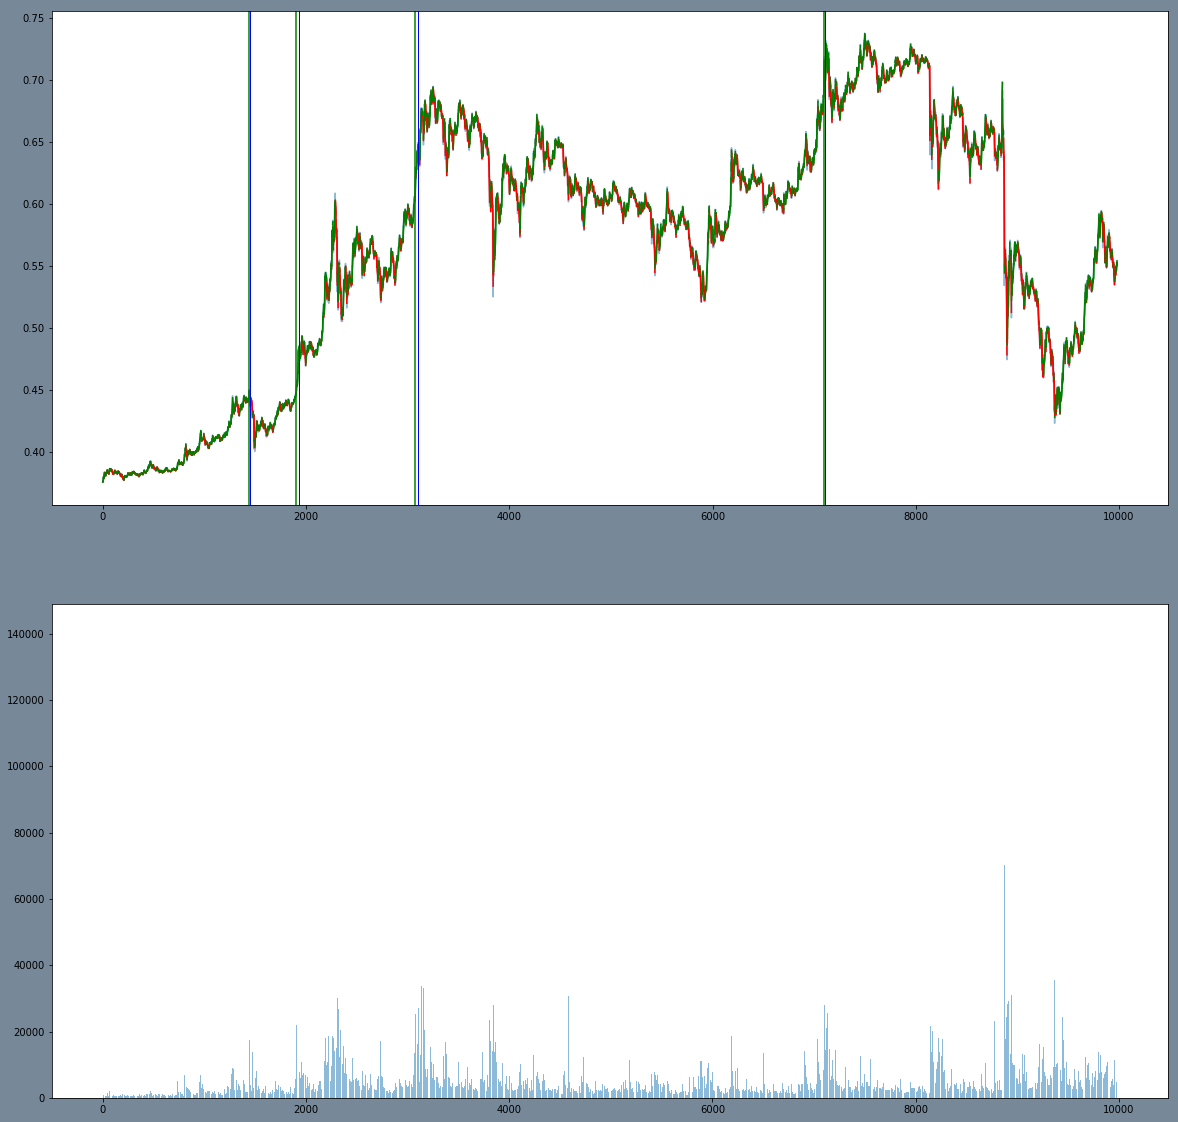

In [536]:
#Matplotlib

f = plt.figure(facecolor='LightSlateGray')
f.set_figwidth(20)
f.set_figheight(20)

num_rows= 2

#plot 1:
plt.subplot(num_rows, 1, 1)
# plt.plot(data_testing.index.to_numpy(),inst['close'], alpha=0.5)
# plt.plot(data_testing.index.to_numpy(),inst['low'], alpha=0.5)
# plt.plot(data_testing.index.to_numpy(),inst['high'], alpha=0.5)

plt.plot(data_testing.index.to_numpy(),data_testing['close'], alpha=0.5)
# plt.plot(inst.index.to_numpy(), renko_chart)
# plt.plot(inst.index.to_numpy(),jma_0_minus_chart,color = 'red')
# plt.plot(inst.index.to_numpy(),jma_0_plus_chart,color = 'green')
plt.plot(data_testing.index.to_numpy(),jma_1_minus_chart,color = 'red')
plt.plot(data_testing.index.to_numpy(),jma_1_plus_chart,color = 'green')
plt.plot(data_testing.index.to_numpy(),jma_2_minus_chart,color = 'red')
plt.plot(data_testing.index.to_numpy(),jma_2_plus_chart,color = 'green')
# plt.plot(inst.index.to_numpy(),jma_3_minus_chart,color = 'red')
# plt.plot(inst.index.to_numpy(),jma_3_plus_chart,color = 'green')
# plt.plot(inst.index.to_numpy(), p1_chart)
# plt.plot(inst.index.to_numpy(), p2_chart)
# plt.axhline(y = 0, color = 'b', linestyle = '-')
for b in bought :
    plt.axvline(x = b, color = 'g',linewidth= 1.5)
for s in sold :
    plt.axvline(x = s, color = 'r',linewidth= 1.5)
for c in closed :
    plt.axvline(x = c, color = 'b',linewidth= 1)

#plot 2:
plt.subplot(num_rows, 1, 2)
# plt.plot(inst.index.to_numpy(),inst['trades_1'], alpha=0.5)
plt.bar(data_testing.index.to_numpy(),data_testing['trades'], alpha=0.5)
# plt.plot(inst.index.to_numpy(),inst['trades'], alpha=0.5)
# plt.plot(inst.index.to_numpy(),p1_chart,color = 'red')
# plt.plot(inst.index.to_numpy(),ROC_1_minus_chart,color = 'red')
# plt.plot(inst.index.to_numpy(),ROC_1_plus_chart,color = 'green')
# plt.axhline(y = 0, color = 'grey', linestyle = '-')
# plt.ylim(0.60, 0.70)
# plt.semilogy()
# for b in bought :
#     plt.axvline(x = b, color = 'g',linewidth= 1.5)
# for s in sold :
#     plt.axvline(x = s, color = 'r',linewidth= 1.5)
# for c in closed :
#     plt.axvline(x = c, color = 'b',linewidth= 1)

#plot 3:
# plt.subplot(num_rows, 1, 3)
# plt.bar(inst.index.to_numpy(),inst['close'].pct_change(1)/inst['trades'].pct_change(1), alpha=0.5)
# plt.bar(inst.index.to_numpy(),inst['volume'], alpha=0.5)
# plt.plot(inst.index.to_numpy(),inst['pct_change'], alpha=0.5)
# plt.plot(inst.index.to_numpy(), profit_factor_chart)
# plt.plot(inst.index.to_numpy(), profit_factor_all_chart)
# plt.axhline(y = 1.2, color = 'grey', linestyle = '-')
# plt.plot(inst.index.to_numpy(), p3_chart)
# plt.plot(inst.index.to_numpy(), p4_chart)

plt.show()

In [ ]:
####

In [532]:
# Plotly

num_rows= 2
fig = subplots(rows=num_rows, cols=1)

# fig.add_trace(go.Scatter(x=inst.index, y=renko_org_chart,name='renko org',line_color='red',line_width=1.5,hovertext=inst['datetime']), row=4, col=1)

# fig.add_trace(go.Scatter(x=inst.index, y=renko_mean_chart,name='renko mean',line_color='violet',line_width=1.5,hovertext=inst['datetime']), row=1, col=1)
# fig.add_trace(go.Scatter(x=inst.index, y=renko_chart,name='renko', line_color='red',line_width=1.5,hovertext=inst['datetime']), row=2, col=1)
fig.add_trace(go.Scatter(x=data_testing.index, y=data_testing['close'],name='close_1',line_color='rgba(0, 153, 204,0.1)',line_width=1.5,hovertext=data_testing['datetime']), row=1, col=1)
fig.add_trace(go.Scatter(x=data_testing.index, y=data_testing['high'],name='high_1',line_color='rgba(0, 255, 0, 0.3)',line_width=1.5), row=1, col=1)
fig.add_trace(go.Scatter(x=data_testing.index, y=data_testing['low'],name='low_1',line_color='rgba(255, 0, 0, 0.1)',line_width=1.5), row=1, col=1)
# fig.add_trace(go.Scatter(x=inst.index, y=inst['close_2'],name='close_1',line_width=1.5), row=1, col=1)


fig.add_trace(go.Scatter(x=data_testing.index, y=jma_2_plus_chart,name='JMA1 +',line_color='Green',line_width=1.5), row=1, col=1)
fig.add_trace(go.Scatter(x=data_testing.index, y=jma_2_minus_chart,name='JMA1 -',line_color='Pink',line_width=1.5), row=1, col=1)
fig.add_trace(go.Scatter(x=inst.index, y=jma_3_plus_chart,name='JMA3 +',line_color='Green',line_width=1.5), row=1, col=1)
fig.add_trace(go.Scatter(x=inst.index, y=jma_3_minus_chart,name='JMA3 -',line_color='Pink',line_width=1.5), row=1, col=1)
# fig.add_trace(go.Scatter(x=inst.index, y=jma_plus_0_chart,name='JMA0 +',line_color='limegreen',line_width=1.5), row=2, col=1)
# fig.add_trace(go.Scatter(x=inst.index, y=jma_minus_0_chart,name='JMA0 -',line_color='orange',line_width=1.5), row=2, col=1)


for b in bought:
    fig.add_shape(type='line',x0=b,x1=b,y0=data_testing['close'].min(),y1=data_testing['close'].max(),line_color='green',line_width=1, row=1, col=1)
for s in sold:
    fig.add_shape(type='line',x0=s,x1=s,y0=data_testing['close'].min(),y1=data_testing['close'].max(),line_color='red',line_width=1, row=1, col=1)
for c in closed:
    fig.add_shape(type='line',x0=c,x1=c,y0=data_testing['close'].min(),y1=data_testing['close'].max(),line_color='black',line_width=1, row=1, col=1)


# fig.add_trace(go.Scatter(x=inst.index, y=ROC_plus_chart,name='ROC +',line_color='Green',line_width=1.5), row=2, col=1)
# fig.add_trace(go.Scatter(x=inst.index, y=ROC_minus_chart,name='ROC -',line_color='Pink',line_width=1.5), row=2, col=1)
# fig.add_trace(go.Scatter(x=inst.index, y=jma_3_plus_chart,name='JMA2 +',line_color='Green',line_width=1.5), row=2, col=1)
# fig.add_trace(go.Scatter(x=inst.index, y=jma_3_minus_chart,name='JMA2 -',line_color='Pink',line_width=1.5), row=2, col=1)
fig.add_trace(go.Scatter(x=data_testing.index, y=data_testing['volume'],name='volume',line_color='grey',line_width=1.5), row=2, col=1)
# fig.add_trace(go.Scatter(x=data_testing.index, y=(data_testing['close'].diff(1)/data_testing['trades']).diff(1),name='volume',line_color='grey',line_width=1.5), row=2, col=1)

# for b in bought:
#     fig.add_shape(type='line',x0=b,x1=b,y0=min(ROC_minus_chart),y1=max(ROC_plus_chart),line_color='green',line_width=1, row=2, col=1)
# for s in sold:
#     fig.add_shape(type='line',x0=s,x1=s,y0=min(ROC_minus_chart),y1=max(ROC_plus_chart),line_color='red',line_width=1, row=2, col=1)
# for c in closed:
#     fig.add_shape(type='line',x0=c,x1=c,y0=min(ROC_minus_chart),y1=max(ROC_plus_chart),line_color='black',line_width=1, row=2, col=1)

# fig.update_yaxes(dtick = 0.1)
# fig.update_yaxes(type="log")
# fig.update_yaxes(hoverformat = '.5f')
# fig.update_layout(xaxis_rangeslider_visible=False)
fig.update_yaxes(fixedrange = False)
fig.update_xaxes(rangeslider_thickness=0.004*num_rows)
fig.update_layout(autosize=False, width=900, height=350*num_rows, margin=dict(l=20, r=20, b=20, t=20))
# fig.update_layout(xaxis=dict(type="date",spikedash = 'solid',spikethickness = 1,spikecolor = 'grey'))
fig.update_layout(hovermode ="x unified")
fig.update_xaxes(matches='x')
# fig.update_xaxes(matches='x', hoverformat = '.5f')
fig.show("notebook")